In [1]:
import os
import torch
import torchvision as tv

from torch import nn
from torch import optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(0))

Device 67df
_CudaDeviceProperties(name='Device 67df', major=8, minor=3, total_memory=8192MB, multi_processor_count=36)


# Generator Network

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, batchnorm=True):
        """A generator for mapping a latent space to a sample space.
        The sample space for this generator is single-channel, 28x28 images
        with pixel intensity ranging from -1 to +1.
        Args:
            latent_dim (int): latent dimension ("noise vector")
            batchnorm (bool): Whether or not to use batch normalization
        """
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.batchnorm = batchnorm
        self._init_modules()

    def _init_modules(self):
        """Initialize the modules."""
        # Project the input
        self.linear1 = nn.Linear(self.latent_dim, 256*7*7, bias=False)
        self.bn1d1 = nn.BatchNorm1d(256*7*7) if self.batchnorm else None
        self.leaky_relu = nn.LeakyReLU()

        # Convolutions
        self.conv1 = nn.Conv2d(
                in_channels=256,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2,
                bias=False)
        self.bn2d1 = nn.BatchNorm2d(128) if self.batchnorm else None

        self.conv2 = nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.bn2d2 = nn.BatchNorm2d(64) if self.batchnorm else None

        self.conv3 = nn.ConvTranspose2d(
                in_channels=64,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.tanh = nn.Tanh()

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = self.linear1(input_tensor)
        intermediate = self.bn1d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = intermediate.view((-1, 256, 7, 7))

        intermediate = self.conv1(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv2(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d2(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv3(intermediate)
        output_tensor = self.tanh(intermediate)
        return output_tensor

# Discriminator Network

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        """A discriminator for discerning real from generated images.
        Images must be single-channel and 28x28 pixels.
        Output activation is Sigmoid.
        """
        super(Discriminator, self).__init__()
        self._init_modules()  # I know this is overly-organized. Fight me.

    def _init_modules(self):
        """Initialize the modules."""
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout_2d = nn.Dropout2d(0.3)

        self.conv2 = nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)

        self.linear1 = nn.Linear(128*7*7, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = self.conv1(input_tensor)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = self.conv2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = intermediate.view((-1, 128*7*7))
        intermediate = self.linear1(intermediate)
        output_tensor = self.sigmoid(intermediate)

        return output_tensor

# DCGAN 

In [4]:
class DCGAN():
    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        """A very basic DCGAN class for generating MNIST digits
        Args:
            generator: a Ganerator network
            discriminator: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            dataloader: a pytorch dataloader for loading images
            batch_size: training batch size. Must match that of dataloader
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample images from the generator.
        Images are returned as a 4D tensor of values between -1 and 1.
        Dimensions are (number, channels, height, width). Returns the tensor
        on cpu.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then use self.batch_size
        random latent vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()  # move images to cpu
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self, real_samples):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_epoch(self, print_frequency=10, max_steps=0):
        """Train both networks for one epoch and return the losses.
        Args:
            print_frequency (int): print stats every `print_frequency` steps.
            max_steps (int): End epoch after `max_steps` steps, or set to 0
                             to do the full epoch.
        """
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch, (real_samples, _) in enumerate(self.dataloader):
            real_samples = real_samples.to(self.device)
            ldr_, ldf_ = self.train_step_discriminator(real_samples)
            
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
            loss_g_running += self.train_step_generator()
            
            if print_frequency and (batch+1) % print_frequency == 0:
                print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch+1):.3f},"
                      f" Dr={loss_d_real_running / (batch+1):.3f},"
                      f" Df={loss_d_fake_running / (batch+1):.3f}",
                      end='\r',
                      flush=True)
            if max_steps and batch == max_steps:
                break
        if print_frequency:
            print()
        loss_g_running /= batch
        loss_d_real_running /= batch
        loss_d_fake_running /= batch
        return (loss_g_running, (loss_d_real_running, loss_d_fake_running))

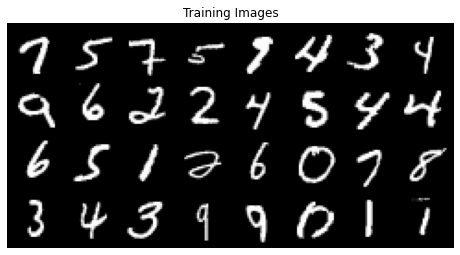

In [11]:
import matplotlib.pyplot as plt
from time import time
import numpy as np
import torchvision.utils as vutils

batch_size = 32
latent_dim = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,), (0.5,))
        ])

dataset = ImageFolder(
        root=os.path.join("data", "mnist_png", "training"),
        transform=transform
        )

dataloader = DataLoader(dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=16
        )

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
noise_fn = lambda x: torch.randn((x, latent_dim), device=device)
gan = DCGAN(latent_dim, noise_fn, dataloader, device=device, batch_size=batch_size)
start = time()

epochs = 100

writer = SummaryWriter()

for i in range(epochs):
    print("===================================================")
    print(f"Epoch {i+1}")    
    loss_g_running, (loss_d_real_running, loss_d_fake_running) = gan.train_epoch()
    writer.add_scalar('Discriminator Loss/Real', loss_d_real_running, i)
    writer.add_scalar('Discriminator Loss/Fake', loss_d_fake_running, i)
    writer.add_scalar('Generator Loss', loss_g_running, i)
    writer.flush()
    print(f"Elapsed time = {int(time() - start)}s")

Epoch 1
1870/1875: G=1.209, Dr=0.548, Df=0.557
Elapsed time = 103s
Epoch 2
1870/1875: G=1.091, Dr=0.578, Df=0.574
Elapsed time = 142s
Epoch 3
1870/1875: G=1.121, Dr=0.573, Df=0.566
Elapsed time = 181s
Epoch 4
1870/1875: G=1.148, Dr=0.566, Df=0.558
Elapsed time = 220s
Epoch 5
1870/1875: G=1.199, Dr=0.554, Df=0.544
Elapsed time = 259s
Epoch 6
1870/1875: G=1.240, Dr=0.543, Df=0.532
Elapsed time = 298s
Epoch 7
1870/1875: G=1.300, Dr=0.528, Df=0.513
Elapsed time = 336s
Epoch 8
1870/1875: G=1.378, Dr=0.513, Df=0.500
Elapsed time = 375s
Epoch 9
1870/1875: G=1.455, Dr=0.498, Df=0.481
Elapsed time = 414s
Epoch 10
1870/1875: G=1.540, Dr=0.477, Df=0.463
Elapsed time = 453s
Epoch 11
1870/1875: G=1.614, Dr=0.464, Df=0.449
Elapsed time = 492s
Epoch 12
1870/1875: G=1.668, Dr=0.457, Df=0.438
Elapsed time = 531s
Epoch 13
1870/1875: G=1.743, Dr=0.443, Df=0.425
Elapsed time = 570s
Epoch 14
1870/1875: G=1.794, Dr=0.437, Df=0.422
Elapsed time = 609s
Epoch 15
1870/1875: G=1.825, Dr=0.430, Df=0.410
Elapsed t

1870/1875: G=1.488, Dr=0.500, Df=0.478
Elapsed time = 2743s
Epoch 70
1870/1875: G=1.488, Dr=0.501, Df=0.483
Elapsed time = 2781s
Epoch 71
1870/1875: G=1.502, Dr=0.498, Df=0.474
Elapsed time = 2820s
Epoch 72
1870/1875: G=1.491, Dr=0.500, Df=0.480
Elapsed time = 2859s
Epoch 73
1870/1875: G=1.490, Dr=0.502, Df=0.480
Elapsed time = 2897s
Epoch 74
1870/1875: G=1.496, Dr=0.500, Df=0.480
Elapsed time = 2936s
Epoch 75
1870/1875: G=1.500, Dr=0.497, Df=0.476
Elapsed time = 2975s
Epoch 76
1870/1875: G=1.482, Dr=0.502, Df=0.479
Elapsed time = 3014s
Epoch 77
1870/1875: G=1.503, Dr=0.500, Df=0.478
Elapsed time = 3052s
Epoch 78
1870/1875: G=1.494, Dr=0.498, Df=0.479
Elapsed time = 3091s
Epoch 79
1870/1875: G=1.489, Dr=0.500, Df=0.480
Elapsed time = 3130s
Epoch 80
1870/1875: G=1.486, Dr=0.497, Df=0.478
Elapsed time = 3169s
Epoch 81
1870/1875: G=1.492, Dr=0.499, Df=0.478
Elapsed time = 3207s
Epoch 82
1870/1875: G=1.503, Dr=0.498, Df=0.479
Elapsed time = 3246s
Epoch 83
1870/1875: G=1.502, Dr=0.496, Df=0

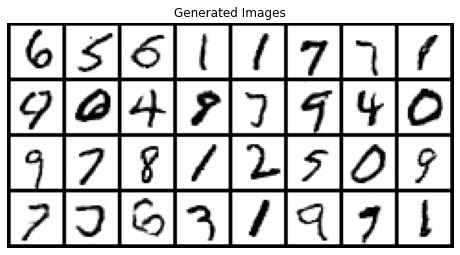

In [13]:
images = gan.generate_samples() * -1  # invert colours, for aesthetics
ims = tv.utils.make_grid(images, normalize=True)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(ims.numpy().transpose((1,2,0)))
plt.show()